<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/15b_U_Net_Train_7chanels_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: NVIDIA A100-SXM4-40GB


In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-05-21 01:07:37--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-05-21 01:07:38--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.06s   

2025-05-21 01:07:38 (13.4 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

In [ ]:
def normalized_index(B1, B2):
  x = (B2 - B1) / (B2 + B1)
  x = np.nan_to_num(x, nan=0.0, posinf= 1.0)
  x = (x + 1 ) / 2
  x = np.expand_dims(x, axis=1)
  return x


https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
# import the necessary packages
#from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [ ]:
class Encoder(Module):
	def __init__(self, channels=(7, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [ ]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [ ]:
class UNet(Module):
  def __init__(self, encChannels=(7, 16, 32, 64),
              decChannels=(64, 32, 16),
              nbClasses=1, retainDim=True,
              #outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
              outSize=(64,  64)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    # return the segmentation map

    return map

# Load Data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5']

In [ ]:
# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_01_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_1 = f['AOI_01_X'][::2]
    data_y_1 = f['AOI_01_y'][::2]
    print(data_X_1.shape, data_y_1.shape)

# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_03_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_2 = f['AOI_03_X'][::2]
    data_y_2 = f['AOI_03_y'][::2]
    print(data_X_2.shape, data_y_2.shape)

data_X = np.concatenate((data_X_1, data_X_2), axis=0)
data_y = np.concatenate((data_y_1, data_y_2), axis=0)
print(data_X.shape, data_y.shape)

Keys: ['AOI_01_FC_percentaje', 'AOI_01_X', 'AOI_01_y']
(47250, 7, 64, 64) (47250, 64, 64)
Keys: ['AOI_03_FC_percentaje', 'AOI_03_X', 'AOI_03_y']
(47250, 7, 64, 64) (47250, 64, 64)
(94500, 7, 64, 64) (94500, 64, 64)


In [ ]:
data_X.shape, data_y.shape

((94500, 7, 64, 64), (94500, 64, 64))

## New channels

In [ ]:
# B3 --> axis 2
# B6 --> axis 5
# B4_B1 --> axis 7
data_X = np.concatenate((data_X, normalized_index(data_X[:, 0, :, :], data_X[:, 3, :, :])), axis=1)

# B4_B3 --> axis 8
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 3, :, :])), axis=1)

# B7_B3 --> axis 9
data_X = np.concatenate((data_X, normalized_index(data_X[:, 2, :, :], data_X[:, 6, :, :])), axis=1)

# B6_B4 --> axis 10
data_X = np.concatenate((data_X, normalized_index(data_X[:, 3, :, :], data_X[:, 5, :, :])), axis=1)

# B6_B5 --> axis 11
data_X = np.concatenate((data_X, normalized_index(data_X[:, 4, :, :], data_X[:, 5, :, :])), axis=1)

data_X.shape

<ipython-input-10-9a76386516fa>:2: RuntimeWarning: invalid value encountered in divide
  x = (B2 - B1) / (B2 + B1)


(94500, 12, 64, 64)

In [ ]:
# Tomar las 7 bandas de interes segun los otros algoritmos Reg Log y Rand Forest
data_X = data_X[:,[2, 5, 7 , 8, 9, 10, 11],:,:]
data_X.shape

(94500, 7, 64, 64)

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X,
                                                    data_y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float

print(X_train.shape, y_train.shape)

torch.Size([75600, 7, 64, 64]) torch.Size([75600, 1, 64, 64])


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float#, dtype=torch.long).squeeze()

print(X_test.shape, y_test.shape)

torch.Size([18900, 7, 64, 64]) torch.Size([18900, 1, 64, 64])


In [ ]:
# Agrupar en un dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01... 256 con GPU 02
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01 ... 256 con GPU 02
                         shuffle=False, num_workers=2)

## Train

In [ ]:
# import the necessary packages
#from pyimagesearch.dataset import SegmentationDataset
#from pyimagesearch.model import UNet
#from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [ ]:
lr_unet = 0.0001

# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=lr_unet)
# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(test_dataset) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
NUM_EPOCHS = 400

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 1/400 [00:12<1:19:54, 12.02s/it]

[INFO] EPOCH: 1/400
Train loss: 0.395126, Test loss: 0.3523


  0%|          | 2/400 [00:22<1:13:10, 11.03s/it]

[INFO] EPOCH: 2/400
Train loss: 0.330268, Test loss: 0.3086


  1%|          | 3/400 [00:32<1:11:02, 10.74s/it]

[INFO] EPOCH: 3/400
Train loss: 0.306027, Test loss: 0.3004


  1%|          | 4/400 [00:43<1:09:55, 10.59s/it]

[INFO] EPOCH: 4/400
Train loss: 0.298843, Test loss: 0.3016


  1%|▏         | 5/400 [00:53<1:09:04, 10.49s/it]

[INFO] EPOCH: 5/400
Train loss: 0.291661, Test loss: 0.2893


  2%|▏         | 6/400 [01:03<1:08:37, 10.45s/it]

[INFO] EPOCH: 6/400
Train loss: 0.286416, Test loss: 0.2846


  2%|▏         | 7/400 [01:14<1:08:08, 10.40s/it]

[INFO] EPOCH: 7/400
Train loss: 0.282670, Test loss: 0.2817


  2%|▏         | 8/400 [01:24<1:07:48, 10.38s/it]

[INFO] EPOCH: 8/400
Train loss: 0.280904, Test loss: 0.2793


  2%|▏         | 9/400 [01:34<1:07:34, 10.37s/it]

[INFO] EPOCH: 9/400
Train loss: 0.278962, Test loss: 0.2802


  2%|▎         | 10/400 [01:45<1:07:20, 10.36s/it]

[INFO] EPOCH: 10/400
Train loss: 0.278163, Test loss: 0.2764


  3%|▎         | 11/400 [01:55<1:07:09, 10.36s/it]

[INFO] EPOCH: 11/400
Train loss: 0.276001, Test loss: 0.2768


  3%|▎         | 12/400 [02:05<1:06:58, 10.36s/it]

[INFO] EPOCH: 12/400
Train loss: 0.275237, Test loss: 0.2740


  3%|▎         | 13/400 [02:16<1:06:48, 10.36s/it]

[INFO] EPOCH: 13/400
Train loss: 0.274465, Test loss: 0.2728


  4%|▎         | 14/400 [02:26<1:06:36, 10.35s/it]

[INFO] EPOCH: 14/400
Train loss: 0.273653, Test loss: 0.2717


  4%|▍         | 15/400 [02:36<1:06:30, 10.37s/it]

[INFO] EPOCH: 15/400
Train loss: 0.271944, Test loss: 0.2763


  4%|▍         | 16/400 [02:47<1:06:16, 10.36s/it]

[INFO] EPOCH: 16/400
Train loss: 0.270287, Test loss: 0.2722


  4%|▍         | 17/400 [02:57<1:06:06, 10.36s/it]

[INFO] EPOCH: 17/400
Train loss: 0.268431, Test loss: 0.2744


  4%|▍         | 18/400 [03:07<1:05:51, 10.34s/it]

[INFO] EPOCH: 18/400
Train loss: 0.267717, Test loss: 0.2692


  5%|▍         | 19/400 [03:18<1:05:38, 10.34s/it]

[INFO] EPOCH: 19/400
Train loss: 0.266246, Test loss: 0.2665


  5%|▌         | 20/400 [03:28<1:05:36, 10.36s/it]

[INFO] EPOCH: 20/400
Train loss: 0.264632, Test loss: 0.2639


  5%|▌         | 21/400 [03:39<1:05:26, 10.36s/it]

[INFO] EPOCH: 21/400
Train loss: 0.263148, Test loss: 0.2627


  6%|▌         | 22/400 [03:49<1:05:42, 10.43s/it]

[INFO] EPOCH: 22/400
Train loss: 0.262991, Test loss: 0.2609


  6%|▌         | 23/400 [03:59<1:05:19, 10.40s/it]

[INFO] EPOCH: 23/400
Train loss: 0.260266, Test loss: 0.2594


  6%|▌         | 24/400 [04:10<1:05:02, 10.38s/it]

[INFO] EPOCH: 24/400
Train loss: 0.260034, Test loss: 0.2588


  6%|▋         | 25/400 [04:20<1:04:48, 10.37s/it]

[INFO] EPOCH: 25/400
Train loss: 0.257230, Test loss: 0.2558


  6%|▋         | 26/400 [04:30<1:04:36, 10.37s/it]

[INFO] EPOCH: 26/400
Train loss: 0.256605, Test loss: 0.2540


  7%|▋         | 27/400 [04:41<1:04:32, 10.38s/it]

[INFO] EPOCH: 27/400
Train loss: 0.254648, Test loss: 0.2557


  7%|▋         | 28/400 [04:51<1:04:16, 10.37s/it]

[INFO] EPOCH: 28/400
Train loss: 0.252572, Test loss: 0.2509


  7%|▋         | 29/400 [05:02<1:04:06, 10.37s/it]

[INFO] EPOCH: 29/400
Train loss: 0.250343, Test loss: 0.2496


  8%|▊         | 30/400 [05:12<1:04:00, 10.38s/it]

[INFO] EPOCH: 30/400
Train loss: 0.249265, Test loss: 0.2469


  8%|▊         | 31/400 [05:22<1:03:49, 10.38s/it]

[INFO] EPOCH: 31/400
Train loss: 0.246423, Test loss: 0.2446


  8%|▊         | 32/400 [05:33<1:03:43, 10.39s/it]

[INFO] EPOCH: 32/400
Train loss: 0.245543, Test loss: 0.2433


  8%|▊         | 33/400 [05:43<1:03:31, 10.39s/it]

[INFO] EPOCH: 33/400
Train loss: 0.244054, Test loss: 0.2415


  8%|▊         | 34/400 [05:54<1:03:16, 10.37s/it]

[INFO] EPOCH: 34/400
Train loss: 0.240768, Test loss: 0.2403


  9%|▉         | 35/400 [06:04<1:03:02, 10.36s/it]

[INFO] EPOCH: 35/400
Train loss: 0.239258, Test loss: 0.2380


  9%|▉         | 36/400 [06:14<1:02:51, 10.36s/it]

[INFO] EPOCH: 36/400
Train loss: 0.238145, Test loss: 0.2343


  9%|▉         | 37/400 [06:25<1:02:51, 10.39s/it]

[INFO] EPOCH: 37/400
Train loss: 0.236520, Test loss: 0.2384


 10%|▉         | 38/400 [06:35<1:02:44, 10.40s/it]

[INFO] EPOCH: 38/400
Train loss: 0.233535, Test loss: 0.2366


 10%|▉         | 39/400 [06:45<1:02:30, 10.39s/it]

[INFO] EPOCH: 39/400
Train loss: 0.231789, Test loss: 0.2300


 10%|█         | 40/400 [06:56<1:02:17, 10.38s/it]

[INFO] EPOCH: 40/400
Train loss: 0.230355, Test loss: 0.2336


 10%|█         | 41/400 [07:06<1:02:08, 10.38s/it]

[INFO] EPOCH: 41/400
Train loss: 0.226865, Test loss: 0.2259


 10%|█         | 42/400 [07:17<1:01:51, 10.37s/it]

[INFO] EPOCH: 42/400
Train loss: 0.226057, Test loss: 0.2251


 11%|█         | 43/400 [07:27<1:01:39, 10.36s/it]

[INFO] EPOCH: 43/400
Train loss: 0.223616, Test loss: 0.2340


 11%|█         | 44/400 [07:37<1:01:25, 10.35s/it]

[INFO] EPOCH: 44/400
Train loss: 0.221412, Test loss: 0.2209


 11%|█▏        | 45/400 [07:48<1:01:13, 10.35s/it]

[INFO] EPOCH: 45/400
Train loss: 0.218008, Test loss: 0.2282


 12%|█▏        | 46/400 [07:58<1:01:06, 10.36s/it]

[INFO] EPOCH: 46/400
Train loss: 0.217007, Test loss: 0.2137


 12%|█▏        | 47/400 [08:08<1:00:51, 10.34s/it]

[INFO] EPOCH: 47/400
Train loss: 0.214999, Test loss: 0.2104


 12%|█▏        | 48/400 [08:19<1:00:38, 10.34s/it]

[INFO] EPOCH: 48/400
Train loss: 0.212231, Test loss: 0.2105


 12%|█▏        | 49/400 [08:29<1:00:31, 10.35s/it]

[INFO] EPOCH: 49/400
Train loss: 0.209108, Test loss: 0.2100


 12%|█▎        | 50/400 [08:39<1:00:19, 10.34s/it]

[INFO] EPOCH: 50/400
Train loss: 0.207567, Test loss: 0.2146


 13%|█▎        | 51/400 [08:50<1:00:09, 10.34s/it]

[INFO] EPOCH: 51/400
Train loss: 0.205906, Test loss: 0.2019


 13%|█▎        | 52/400 [09:00<59:59, 10.34s/it]  

[INFO] EPOCH: 52/400
Train loss: 0.204739, Test loss: 0.2007


 13%|█▎        | 53/400 [09:10<59:46, 10.33s/it]

[INFO] EPOCH: 53/400
Train loss: 0.201956, Test loss: 0.2186


 14%|█▎        | 54/400 [09:21<59:34, 10.33s/it]

[INFO] EPOCH: 54/400
Train loss: 0.199638, Test loss: 0.1995


 14%|█▍        | 55/400 [09:31<59:23, 10.33s/it]

[INFO] EPOCH: 55/400
Train loss: 0.197302, Test loss: 0.1947


 14%|█▍        | 56/400 [09:41<59:12, 10.33s/it]

[INFO] EPOCH: 56/400
Train loss: 0.195406, Test loss: 0.1934


 14%|█▍        | 57/400 [09:52<59:07, 10.34s/it]

[INFO] EPOCH: 57/400
Train loss: 0.194268, Test loss: 0.1914


 14%|█▍        | 58/400 [10:02<59:02, 10.36s/it]

[INFO] EPOCH: 58/400
Train loss: 0.191518, Test loss: 0.1929


 15%|█▍        | 59/400 [10:12<58:52, 10.36s/it]

[INFO] EPOCH: 59/400
Train loss: 0.188709, Test loss: 0.1937


 15%|█▌        | 60/400 [10:23<58:40, 10.35s/it]

[INFO] EPOCH: 60/400
Train loss: 0.189885, Test loss: 0.1906


 15%|█▌        | 61/400 [10:33<58:33, 10.36s/it]

[INFO] EPOCH: 61/400
Train loss: 0.186673, Test loss: 0.1822


 16%|█▌        | 62/400 [10:43<58:21, 10.36s/it]

[INFO] EPOCH: 62/400
Train loss: 0.184047, Test loss: 0.1798


 16%|█▌        | 63/400 [10:54<58:11, 10.36s/it]

[INFO] EPOCH: 63/400
Train loss: 0.182078, Test loss: 0.1795


 16%|█▌        | 64/400 [11:04<57:55, 10.35s/it]

[INFO] EPOCH: 64/400
Train loss: 0.182016, Test loss: 0.1790


 16%|█▋        | 65/400 [11:15<57:49, 10.36s/it]

[INFO] EPOCH: 65/400
Train loss: 0.179092, Test loss: 0.1762


 16%|█▋        | 66/400 [11:25<57:40, 10.36s/it]

[INFO] EPOCH: 66/400
Train loss: 0.176980, Test loss: 0.2160


 17%|█▋        | 67/400 [11:35<57:30, 10.36s/it]

[INFO] EPOCH: 67/400
Train loss: 0.176435, Test loss: 0.1724


 17%|█▋        | 68/400 [11:46<57:18, 10.36s/it]

[INFO] EPOCH: 68/400
Train loss: 0.172732, Test loss: 0.1945


 17%|█▋        | 69/400 [11:56<57:09, 10.36s/it]

[INFO] EPOCH: 69/400
Train loss: 0.175339, Test loss: 0.1791


 18%|█▊        | 70/400 [12:06<56:58, 10.36s/it]

[INFO] EPOCH: 70/400
Train loss: 0.171491, Test loss: 0.1671


 18%|█▊        | 71/400 [12:17<56:44, 10.35s/it]

[INFO] EPOCH: 71/400
Train loss: 0.167697, Test loss: 0.1702


 18%|█▊        | 72/400 [12:27<56:33, 10.35s/it]

[INFO] EPOCH: 72/400
Train loss: 0.170171, Test loss: 0.1790


 18%|█▊        | 73/400 [12:37<56:23, 10.35s/it]

[INFO] EPOCH: 73/400
Train loss: 0.166975, Test loss: 0.1648


 18%|█▊        | 74/400 [12:48<56:14, 10.35s/it]

[INFO] EPOCH: 74/400
Train loss: 0.165802, Test loss: 0.1645


 19%|█▉        | 75/400 [12:58<56:04, 10.35s/it]

[INFO] EPOCH: 75/400
Train loss: 0.162819, Test loss: 0.1655


 19%|█▉        | 76/400 [13:08<55:52, 10.35s/it]

[INFO] EPOCH: 76/400
Train loss: 0.163884, Test loss: 0.1717


 19%|█▉        | 77/400 [13:19<55:41, 10.35s/it]

[INFO] EPOCH: 77/400
Train loss: 0.162483, Test loss: 0.1593


 20%|█▉        | 78/400 [13:29<55:32, 10.35s/it]

[INFO] EPOCH: 78/400
Train loss: 0.157809, Test loss: 0.1550


 20%|█▉        | 79/400 [13:39<55:22, 10.35s/it]

[INFO] EPOCH: 79/400
Train loss: 0.160261, Test loss: 0.1560


 20%|██        | 80/400 [13:50<55:27, 10.40s/it]

[INFO] EPOCH: 80/400
Train loss: 0.156016, Test loss: 0.1574


 20%|██        | 81/400 [14:00<55:12, 10.38s/it]

[INFO] EPOCH: 81/400
Train loss: 0.157941, Test loss: 0.1640


 20%|██        | 82/400 [14:11<54:58, 10.37s/it]

[INFO] EPOCH: 82/400
Train loss: 0.154669, Test loss: 0.1588


 21%|██        | 83/400 [14:21<54:48, 10.37s/it]

[INFO] EPOCH: 83/400
Train loss: 0.155200, Test loss: 0.1489


 21%|██        | 84/400 [14:31<54:33, 10.36s/it]

[INFO] EPOCH: 84/400
Train loss: 0.151546, Test loss: 0.1482


 21%|██▏       | 85/400 [14:42<54:22, 10.36s/it]

[INFO] EPOCH: 85/400
Train loss: 0.151089, Test loss: 0.1533


 22%|██▏       | 86/400 [14:52<54:13, 10.36s/it]

[INFO] EPOCH: 86/400
Train loss: 0.151819, Test loss: 0.1483


 22%|██▏       | 87/400 [15:02<54:02, 10.36s/it]

[INFO] EPOCH: 87/400
Train loss: 0.150337, Test loss: 0.1531


 22%|██▏       | 88/400 [15:13<53:57, 10.38s/it]

[INFO] EPOCH: 88/400
Train loss: 0.150309, Test loss: 0.1530


 22%|██▏       | 89/400 [15:23<53:47, 10.38s/it]

[INFO] EPOCH: 89/400
Train loss: 0.149367, Test loss: 0.1464


 22%|██▎       | 90/400 [15:34<53:33, 10.36s/it]

[INFO] EPOCH: 90/400
Train loss: 0.143693, Test loss: 0.1420


 23%|██▎       | 91/400 [15:44<53:23, 10.37s/it]

[INFO] EPOCH: 91/400
Train loss: 0.145013, Test loss: 0.1437


 23%|██▎       | 92/400 [15:54<53:17, 10.38s/it]

[INFO] EPOCH: 92/400
Train loss: 0.144771, Test loss: 0.1423


 23%|██▎       | 93/400 [16:05<53:03, 10.37s/it]

[INFO] EPOCH: 93/400
Train loss: 0.141746, Test loss: 0.1520


 24%|██▎       | 94/400 [16:15<52:57, 10.39s/it]

[INFO] EPOCH: 94/400
Train loss: 0.140510, Test loss: 0.1384


 24%|██▍       | 95/400 [16:26<52:47, 10.39s/it]

[INFO] EPOCH: 95/400
Train loss: 0.143145, Test loss: 0.1384


 24%|██▍       | 96/400 [16:36<52:53, 10.44s/it]

[INFO] EPOCH: 96/400
Train loss: 0.138735, Test loss: 0.1439


 24%|██▍       | 97/400 [16:46<52:37, 10.42s/it]

[INFO] EPOCH: 97/400
Train loss: 0.140259, Test loss: 0.1374


 24%|██▍       | 98/400 [16:57<52:21, 10.40s/it]

[INFO] EPOCH: 98/400
Train loss: 0.136370, Test loss: 0.1462


 25%|██▍       | 99/400 [17:07<52:05, 10.38s/it]

[INFO] EPOCH: 99/400
Train loss: 0.136301, Test loss: 0.1336


 25%|██▌       | 100/400 [17:18<51:54, 10.38s/it]

[INFO] EPOCH: 100/400
Train loss: 0.136971, Test loss: 0.1331


 25%|██▌       | 101/400 [17:28<51:39, 10.37s/it]

[INFO] EPOCH: 101/400
Train loss: 0.135815, Test loss: 0.1498


 26%|██▌       | 102/400 [17:38<51:27, 10.36s/it]

[INFO] EPOCH: 102/400
Train loss: 0.134484, Test loss: 0.1488


 26%|██▌       | 103/400 [17:49<51:17, 10.36s/it]

[INFO] EPOCH: 103/400
Train loss: 0.132757, Test loss: 0.1291


 26%|██▌       | 104/400 [17:59<51:09, 10.37s/it]

[INFO] EPOCH: 104/400
Train loss: 0.134272, Test loss: 0.1326


 26%|██▋       | 105/400 [18:09<50:59, 10.37s/it]

[INFO] EPOCH: 105/400
Train loss: 0.132019, Test loss: 0.1349


 26%|██▋       | 106/400 [18:20<51:11, 10.45s/it]

[INFO] EPOCH: 106/400
Train loss: 0.132151, Test loss: 0.1265


 27%|██▋       | 107/400 [18:30<50:53, 10.42s/it]

[INFO] EPOCH: 107/400
Train loss: 0.128334, Test loss: 0.1273


 27%|██▋       | 108/400 [18:41<50:37, 10.40s/it]

[INFO] EPOCH: 108/400
Train loss: 0.128899, Test loss: 0.1323


 27%|██▋       | 109/400 [18:51<50:26, 10.40s/it]

[INFO] EPOCH: 109/400
Train loss: 0.130375, Test loss: 0.1435


 28%|██▊       | 110/400 [19:01<50:10, 10.38s/it]

[INFO] EPOCH: 110/400
Train loss: 0.126734, Test loss: 0.1248


 28%|██▊       | 111/400 [19:12<49:57, 10.37s/it]

[INFO] EPOCH: 111/400
Train loss: 0.129300, Test loss: 0.1284


 28%|██▊       | 112/400 [19:22<49:45, 10.37s/it]

[INFO] EPOCH: 112/400
Train loss: 0.124933, Test loss: 0.1383


 28%|██▊       | 113/400 [19:32<49:35, 10.37s/it]

[INFO] EPOCH: 113/400
Train loss: 0.127099, Test loss: 0.1240


 28%|██▊       | 114/400 [19:43<49:24, 10.37s/it]

[INFO] EPOCH: 114/400
Train loss: 0.125063, Test loss: 0.1257


 29%|██▉       | 115/400 [19:53<49:14, 10.37s/it]

[INFO] EPOCH: 115/400
Train loss: 0.125054, Test loss: 0.1241


 29%|██▉       | 116/400 [20:04<49:07, 10.38s/it]

[INFO] EPOCH: 116/400
Train loss: 0.126993, Test loss: 0.1195


 29%|██▉       | 117/400 [20:14<48:55, 10.37s/it]

[INFO] EPOCH: 117/400
Train loss: 0.122095, Test loss: 0.1186


 30%|██▉       | 118/400 [20:24<48:42, 10.37s/it]

[INFO] EPOCH: 118/400
Train loss: 0.123546, Test loss: 0.1196


 30%|██▉       | 119/400 [20:35<48:35, 10.38s/it]

[INFO] EPOCH: 119/400
Train loss: 0.121002, Test loss: 0.1193


 30%|███       | 120/400 [20:45<48:40, 10.43s/it]

[INFO] EPOCH: 120/400
Train loss: 0.122345, Test loss: 0.1182


 30%|███       | 121/400 [20:56<48:21, 10.40s/it]

[INFO] EPOCH: 121/400
Train loss: 0.118896, Test loss: 0.1319


 30%|███       | 122/400 [21:06<48:08, 10.39s/it]

[INFO] EPOCH: 122/400
Train loss: 0.123674, Test loss: 0.1155


 31%|███       | 123/400 [21:16<47:55, 10.38s/it]

[INFO] EPOCH: 123/400
Train loss: 0.118505, Test loss: 0.1197


 31%|███       | 124/400 [21:27<47:41, 10.37s/it]

[INFO] EPOCH: 124/400
Train loss: 0.118652, Test loss: 0.1137


 31%|███▏      | 125/400 [21:37<47:33, 10.38s/it]

[INFO] EPOCH: 125/400
Train loss: 0.116357, Test loss: 0.1137


 32%|███▏      | 126/400 [21:47<47:22, 10.38s/it]

[INFO] EPOCH: 126/400
Train loss: 0.118117, Test loss: 0.1188


 32%|███▏      | 127/400 [21:58<47:14, 10.38s/it]

[INFO] EPOCH: 127/400
Train loss: 0.117421, Test loss: 0.1157


 32%|███▏      | 128/400 [22:08<47:25, 10.46s/it]

[INFO] EPOCH: 128/400
Train loss: 0.116414, Test loss: 0.1215


 32%|███▏      | 129/400 [22:19<47:26, 10.51s/it]

[INFO] EPOCH: 129/400
Train loss: 0.117692, Test loss: 0.1135


 32%|███▎      | 130/400 [22:30<47:25, 10.54s/it]

[INFO] EPOCH: 130/400
Train loss: 0.115171, Test loss: 0.1157


 33%|███▎      | 131/400 [22:40<47:18, 10.55s/it]

[INFO] EPOCH: 131/400
Train loss: 0.114096, Test loss: 0.1100


 33%|███▎      | 132/400 [22:51<47:10, 10.56s/it]

[INFO] EPOCH: 132/400
Train loss: 0.119603, Test loss: 0.1407


 33%|███▎      | 133/400 [23:02<47:06, 10.59s/it]

[INFO] EPOCH: 133/400
Train loss: 0.115054, Test loss: 0.1491


 34%|███▎      | 134/400 [23:12<46:59, 10.60s/it]

[INFO] EPOCH: 134/400
Train loss: 0.114343, Test loss: 0.1089


 34%|███▍      | 135/400 [23:23<46:49, 10.60s/it]

[INFO] EPOCH: 135/400
Train loss: 0.112409, Test loss: 0.1157


 34%|███▍      | 136/400 [23:33<46:43, 10.62s/it]

[INFO] EPOCH: 136/400
Train loss: 0.114923, Test loss: 0.1226


 34%|███▍      | 137/400 [23:44<46:31, 10.62s/it]

[INFO] EPOCH: 137/400
Train loss: 0.110858, Test loss: 0.1070


 34%|███▍      | 138/400 [23:55<46:18, 10.60s/it]

[INFO] EPOCH: 138/400
Train loss: 0.112223, Test loss: 0.1072


 35%|███▍      | 139/400 [24:05<46:08, 10.61s/it]

[INFO] EPOCH: 139/400
Train loss: 0.114413, Test loss: 0.1082


 35%|███▌      | 140/400 [24:16<45:58, 10.61s/it]

[INFO] EPOCH: 140/400
Train loss: 0.113353, Test loss: 0.1057


 35%|███▌      | 141/400 [24:26<45:47, 10.61s/it]

[INFO] EPOCH: 141/400
Train loss: 0.108801, Test loss: 0.1059


 36%|███▌      | 142/400 [24:37<45:39, 10.62s/it]

[INFO] EPOCH: 142/400
Train loss: 0.110398, Test loss: 0.1113


 36%|███▌      | 143/400 [24:48<45:28, 10.61s/it]

[INFO] EPOCH: 143/400
Train loss: 0.112478, Test loss: 0.1091


 36%|███▌      | 144/400 [24:58<45:19, 10.62s/it]

[INFO] EPOCH: 144/400
Train loss: 0.107715, Test loss: 0.1062


 36%|███▋      | 145/400 [25:09<45:07, 10.62s/it]

[INFO] EPOCH: 145/400
Train loss: 0.106494, Test loss: 0.1072


 36%|███▋      | 146/400 [25:20<44:57, 10.62s/it]

[INFO] EPOCH: 146/400
Train loss: 0.111618, Test loss: 0.1060


 37%|███▋      | 147/400 [25:30<44:55, 10.65s/it]

[INFO] EPOCH: 147/400
Train loss: 0.107933, Test loss: 0.1039


 37%|███▋      | 148/400 [25:41<44:40, 10.64s/it]

[INFO] EPOCH: 148/400
Train loss: 0.106199, Test loss: 0.1128


 37%|███▋      | 149/400 [25:51<44:27, 10.63s/it]

[INFO] EPOCH: 149/400
Train loss: 0.105865, Test loss: 0.1023


 38%|███▊      | 150/400 [26:02<44:22, 10.65s/it]

[INFO] EPOCH: 150/400
Train loss: 0.108047, Test loss: 0.1050


 38%|███▊      | 151/400 [26:13<44:08, 10.64s/it]

[INFO] EPOCH: 151/400
Train loss: 0.106149, Test loss: 0.1010


 38%|███▊      | 152/400 [26:23<43:56, 10.63s/it]

[INFO] EPOCH: 152/400
Train loss: 0.104788, Test loss: 0.1021


 38%|███▊      | 153/400 [26:34<43:46, 10.63s/it]

[INFO] EPOCH: 153/400
Train loss: 0.118679, Test loss: 0.1014


 38%|███▊      | 154/400 [26:45<43:33, 10.62s/it]

[INFO] EPOCH: 154/400
Train loss: 0.102185, Test loss: 0.1076


 39%|███▉      | 155/400 [26:55<43:24, 10.63s/it]

[INFO] EPOCH: 155/400
Train loss: 0.115831, Test loss: 0.1031


 39%|███▉      | 156/400 [27:06<43:12, 10.63s/it]

[INFO] EPOCH: 156/400
Train loss: 0.102165, Test loss: 0.1014


 39%|███▉      | 157/400 [27:17<43:10, 10.66s/it]

[INFO] EPOCH: 157/400
Train loss: 0.125706, Test loss: 0.1096


 40%|███▉      | 158/400 [27:27<42:58, 10.66s/it]

[INFO] EPOCH: 158/400
Train loss: 0.103142, Test loss: 0.0987


 40%|███▉      | 159/400 [27:38<42:46, 10.65s/it]

[INFO] EPOCH: 159/400
Train loss: 0.102261, Test loss: 0.1047


 40%|████      | 160/400 [27:49<42:36, 10.65s/it]

[INFO] EPOCH: 160/400
Train loss: 0.101051, Test loss: 0.0995


 40%|████      | 161/400 [27:59<42:32, 10.68s/it]

[INFO] EPOCH: 161/400
Train loss: 0.101603, Test loss: 0.0988


 40%|████      | 162/400 [28:10<42:15, 10.65s/it]

[INFO] EPOCH: 162/400
Train loss: 0.106533, Test loss: 0.0983


 41%|████      | 163/400 [28:21<42:03, 10.65s/it]

[INFO] EPOCH: 163/400
Train loss: 0.107711, Test loss: 0.2381


 41%|████      | 164/400 [28:31<41:53, 10.65s/it]

[INFO] EPOCH: 164/400
Train loss: 0.106194, Test loss: 0.0994


 41%|████▏     | 165/400 [28:42<41:44, 10.66s/it]

[INFO] EPOCH: 165/400
Train loss: 0.099292, Test loss: 0.0984


 42%|████▏     | 166/400 [28:53<41:30, 10.64s/it]

[INFO] EPOCH: 166/400
Train loss: 0.099207, Test loss: 0.1246


 42%|████▏     | 167/400 [29:03<41:17, 10.63s/it]

[INFO] EPOCH: 167/400
Train loss: 0.098631, Test loss: 0.0961


 42%|████▏     | 168/400 [29:14<41:03, 10.62s/it]

[INFO] EPOCH: 168/400
Train loss: 0.101851, Test loss: 0.0995


 42%|████▏     | 169/400 [29:24<40:53, 10.62s/it]

[INFO] EPOCH: 169/400
Train loss: 0.099222, Test loss: 0.0972


 42%|████▎     | 170/400 [29:35<40:41, 10.62s/it]

[INFO] EPOCH: 170/400
Train loss: 0.098476, Test loss: 0.0966


 43%|████▎     | 171/400 [29:46<40:31, 10.62s/it]

[INFO] EPOCH: 171/400
Train loss: 0.115592, Test loss: 0.1117


 43%|████▎     | 172/400 [29:56<40:36, 10.69s/it]

[INFO] EPOCH: 172/400
Train loss: 0.098625, Test loss: 0.1059


 43%|████▎     | 173/400 [30:07<40:25, 10.69s/it]

[INFO] EPOCH: 173/400
Train loss: 0.101520, Test loss: 0.0958


 44%|████▎     | 174/400 [30:18<40:11, 10.67s/it]

[INFO] EPOCH: 174/400
Train loss: 0.098086, Test loss: 0.0989


 44%|████▍     | 175/400 [30:28<39:59, 10.66s/it]

[INFO] EPOCH: 175/400
Train loss: 0.097408, Test loss: 0.0929


 44%|████▍     | 176/400 [30:39<39:45, 10.65s/it]

[INFO] EPOCH: 176/400
Train loss: 0.098635, Test loss: 0.1094


 44%|████▍     | 177/400 [30:50<39:33, 10.65s/it]

[INFO] EPOCH: 177/400
Train loss: 0.096011, Test loss: 0.1032


 44%|████▍     | 178/400 [31:00<39:22, 10.64s/it]

[INFO] EPOCH: 178/400
Train loss: 0.099911, Test loss: 0.0939


 45%|████▍     | 179/400 [31:11<39:09, 10.63s/it]

[INFO] EPOCH: 179/400
Train loss: 0.094246, Test loss: 0.0937


 45%|████▌     | 180/400 [31:22<38:59, 10.63s/it]

[INFO] EPOCH: 180/400
Train loss: 0.097158, Test loss: 0.0936


 45%|████▌     | 181/400 [31:32<38:48, 10.63s/it]

[INFO] EPOCH: 181/400
Train loss: 0.096120, Test loss: 0.0924


 46%|████▌     | 182/400 [31:43<38:37, 10.63s/it]

[INFO] EPOCH: 182/400
Train loss: 0.110771, Test loss: 0.0914


 46%|████▌     | 183/400 [31:53<38:25, 10.63s/it]

[INFO] EPOCH: 183/400
Train loss: 0.093692, Test loss: 0.0938


 46%|████▌     | 184/400 [32:04<38:15, 10.63s/it]

[INFO] EPOCH: 184/400
Train loss: 0.093137, Test loss: 0.0934


 46%|████▋     | 185/400 [32:15<38:15, 10.68s/it]

[INFO] EPOCH: 185/400
Train loss: 0.097875, Test loss: 0.0903


 46%|████▋     | 186/400 [32:25<38:01, 10.66s/it]

[INFO] EPOCH: 186/400
Train loss: 0.096955, Test loss: 0.0908


 47%|████▋     | 187/400 [32:36<37:49, 10.65s/it]

[INFO] EPOCH: 187/400
Train loss: 0.092684, Test loss: 0.0923


 47%|████▋     | 188/400 [32:47<37:37, 10.65s/it]

[INFO] EPOCH: 188/400
Train loss: 0.092536, Test loss: 0.0899


 47%|████▋     | 189/400 [32:57<37:24, 10.64s/it]

[INFO] EPOCH: 189/400
Train loss: 0.096572, Test loss: 0.4216


 48%|████▊     | 190/400 [33:08<37:15, 10.65s/it]

[INFO] EPOCH: 190/400
Train loss: 0.107507, Test loss: 0.1233


 48%|████▊     | 191/400 [33:19<37:05, 10.65s/it]

[INFO] EPOCH: 191/400
Train loss: 0.091902, Test loss: 0.0926


 48%|████▊     | 192/400 [33:29<36:52, 10.64s/it]

[INFO] EPOCH: 192/400
Train loss: 0.095048, Test loss: 0.0889


 48%|████▊     | 193/400 [33:40<36:41, 10.63s/it]

[INFO] EPOCH: 193/400
Train loss: 0.092970, Test loss: 0.0906


 48%|████▊     | 194/400 [33:50<36:29, 10.63s/it]

[INFO] EPOCH: 194/400
Train loss: 0.092258, Test loss: 0.0948


 49%|████▉     | 195/400 [34:01<36:17, 10.62s/it]

[INFO] EPOCH: 195/400
Train loss: 0.095166, Test loss: 0.0885


 49%|████▉     | 196/400 [34:12<36:10, 10.64s/it]

[INFO] EPOCH: 196/400
Train loss: 0.094528, Test loss: 0.1372


 49%|████▉     | 197/400 [34:22<35:58, 10.63s/it]

[INFO] EPOCH: 197/400
Train loss: 0.093586, Test loss: 0.0949


 50%|████▉     | 198/400 [34:33<35:45, 10.62s/it]

[INFO] EPOCH: 198/400
Train loss: 0.090803, Test loss: 0.0941


 50%|████▉     | 199/400 [34:44<35:34, 10.62s/it]

[INFO] EPOCH: 199/400
Train loss: 0.090881, Test loss: 0.0895


 50%|█████     | 200/400 [34:54<35:26, 10.63s/it]

[INFO] EPOCH: 200/400
Train loss: 0.090321, Test loss: 0.0889


 50%|█████     | 201/400 [35:05<35:15, 10.63s/it]

[INFO] EPOCH: 201/400
Train loss: 0.098687, Test loss: 0.0947


 50%|█████     | 202/400 [35:15<35:03, 10.62s/it]

[INFO] EPOCH: 202/400
Train loss: 0.090364, Test loss: 0.0895


 51%|█████     | 203/400 [35:26<34:52, 10.62s/it]

[INFO] EPOCH: 203/400
Train loss: 0.090180, Test loss: 0.0906


 51%|█████     | 204/400 [35:37<34:43, 10.63s/it]

[INFO] EPOCH: 204/400
Train loss: 0.122713, Test loss: 0.0905


 51%|█████▏    | 205/400 [35:47<34:31, 10.62s/it]

[INFO] EPOCH: 205/400
Train loss: 0.088742, Test loss: 0.0902


 52%|█████▏    | 206/400 [35:58<34:40, 10.72s/it]

[INFO] EPOCH: 206/400
Train loss: 0.088904, Test loss: 0.0884


 52%|█████▏    | 207/400 [36:09<34:49, 10.83s/it]

[INFO] EPOCH: 207/400
Train loss: 0.090004, Test loss: 0.0902


 52%|█████▏    | 208/400 [36:20<34:41, 10.84s/it]

[INFO] EPOCH: 208/400
Train loss: 0.090154, Test loss: 0.1088


 52%|█████▏    | 209/400 [36:31<34:34, 10.86s/it]

[INFO] EPOCH: 209/400
Train loss: 0.089203, Test loss: 0.0865


 52%|█████▎    | 210/400 [36:42<34:22, 10.86s/it]

[INFO] EPOCH: 210/400
Train loss: 0.112431, Test loss: 0.0903


 53%|█████▎    | 211/400 [36:53<34:11, 10.85s/it]

[INFO] EPOCH: 211/400
Train loss: 0.089751, Test loss: 0.0864


 53%|█████▎    | 212/400 [37:04<34:02, 10.87s/it]

[INFO] EPOCH: 212/400
Train loss: 0.086785, Test loss: 0.0848


 53%|█████▎    | 213/400 [37:15<33:53, 10.88s/it]

[INFO] EPOCH: 213/400
Train loss: 0.096288, Test loss: 0.0864


 54%|█████▎    | 214/400 [37:26<33:45, 10.89s/it]

[INFO] EPOCH: 214/400
Train loss: 0.086802, Test loss: 0.0909


 54%|█████▍    | 215/400 [37:36<33:34, 10.89s/it]

[INFO] EPOCH: 215/400
Train loss: 0.086855, Test loss: 0.0836


 54%|█████▍    | 216/400 [37:48<33:33, 10.95s/it]

[INFO] EPOCH: 216/400
Train loss: 0.087470, Test loss: 0.0861


 54%|█████▍    | 217/400 [37:59<33:47, 11.08s/it]

[INFO] EPOCH: 217/400
Train loss: 0.108241, Test loss: 0.0961


 55%|█████▍    | 218/400 [38:10<33:27, 11.03s/it]

[INFO] EPOCH: 218/400
Train loss: 0.086629, Test loss: 0.0847


 55%|█████▍    | 219/400 [38:21<33:09, 10.99s/it]

[INFO] EPOCH: 219/400
Train loss: 0.096720, Test loss: 0.4185


 55%|█████▌    | 220/400 [38:32<32:53, 10.96s/it]

[INFO] EPOCH: 220/400
Train loss: 0.117585, Test loss: 0.0896


 55%|█████▌    | 221/400 [38:42<32:36, 10.93s/it]

[INFO] EPOCH: 221/400
Train loss: 0.085689, Test loss: 0.0843


 56%|█████▌    | 222/400 [38:53<32:22, 10.91s/it]

[INFO] EPOCH: 222/400
Train loss: 0.092208, Test loss: 0.0851


 56%|█████▌    | 223/400 [39:04<32:11, 10.91s/it]

[INFO] EPOCH: 223/400
Train loss: 0.088226, Test loss: 0.0851


 56%|█████▌    | 224/400 [39:15<31:58, 10.90s/it]

[INFO] EPOCH: 224/400
Train loss: 0.086682, Test loss: 0.1105


 56%|█████▋    | 225/400 [39:26<31:53, 10.93s/it]

[INFO] EPOCH: 225/400
Train loss: 0.086348, Test loss: 0.1020


 56%|█████▋    | 226/400 [39:37<31:38, 10.91s/it]

[INFO] EPOCH: 226/400
Train loss: 0.085920, Test loss: 0.0841


 57%|█████▋    | 227/400 [39:48<31:26, 10.90s/it]

[INFO] EPOCH: 227/400
Train loss: 0.085951, Test loss: 0.0844


 57%|█████▋    | 228/400 [39:59<31:12, 10.88s/it]

[INFO] EPOCH: 228/400
Train loss: 0.099743, Test loss: 0.0877


 57%|█████▋    | 229/400 [40:10<31:12, 10.95s/it]

[INFO] EPOCH: 229/400
Train loss: 0.083926, Test loss: 0.0815


 57%|█████▊    | 230/400 [40:21<31:09, 11.00s/it]

[INFO] EPOCH: 230/400
Train loss: 0.103524, Test loss: 0.1489


 58%|█████▊    | 231/400 [40:32<30:51, 10.96s/it]

[INFO] EPOCH: 231/400
Train loss: 0.089483, Test loss: 0.0819


 58%|█████▊    | 232/400 [40:43<30:38, 10.94s/it]

[INFO] EPOCH: 232/400
Train loss: 0.084344, Test loss: 0.0810


 58%|█████▊    | 233/400 [40:54<30:26, 10.94s/it]

[INFO] EPOCH: 233/400
Train loss: 0.084262, Test loss: 0.0819


 58%|█████▊    | 234/400 [41:05<30:15, 10.94s/it]

[INFO] EPOCH: 234/400
Train loss: 0.084985, Test loss: 0.0870


 59%|█████▉    | 235/400 [41:16<30:03, 10.93s/it]

[INFO] EPOCH: 235/400
Train loss: 0.083178, Test loss: 0.0811


 59%|█████▉    | 236/400 [41:26<29:51, 10.92s/it]

[INFO] EPOCH: 236/400
Train loss: 0.201772, Test loss: 0.1330


 59%|█████▉    | 237/400 [41:37<29:40, 10.93s/it]

[INFO] EPOCH: 237/400
Train loss: 0.096720, Test loss: 0.0867


 60%|█████▉    | 238/400 [41:48<29:29, 10.92s/it]

[INFO] EPOCH: 238/400
Train loss: 0.085578, Test loss: 0.0820


 60%|█████▉    | 239/400 [41:59<29:20, 10.94s/it]

[INFO] EPOCH: 239/400
Train loss: 0.088847, Test loss: 0.0866


 60%|██████    | 240/400 [42:10<29:10, 10.94s/it]

[INFO] EPOCH: 240/400
Train loss: 0.084695, Test loss: 0.0817


 60%|██████    | 241/400 [42:21<28:59, 10.94s/it]

[INFO] EPOCH: 241/400
Train loss: 0.084489, Test loss: 0.0824


 60%|██████    | 242/400 [42:32<28:50, 10.95s/it]

[INFO] EPOCH: 242/400
Train loss: 0.085399, Test loss: 0.0802


 61%|██████    | 243/400 [42:43<28:41, 10.97s/it]

[INFO] EPOCH: 243/400
Train loss: 0.082190, Test loss: 0.0853


 61%|██████    | 244/400 [42:54<28:29, 10.96s/it]

[INFO] EPOCH: 244/400
Train loss: 0.106189, Test loss: 0.0807


 61%|██████▏   | 245/400 [43:05<28:20, 10.97s/it]

[INFO] EPOCH: 245/400
Train loss: 0.082110, Test loss: 0.0912


 62%|██████▏   | 246/400 [43:16<28:08, 10.96s/it]

[INFO] EPOCH: 246/400
Train loss: 0.083539, Test loss: 0.0867


 62%|██████▏   | 247/400 [43:27<27:56, 10.96s/it]

[INFO] EPOCH: 247/400
Train loss: 0.081993, Test loss: 0.0792


 62%|██████▏   | 248/400 [43:38<27:42, 10.94s/it]

[INFO] EPOCH: 248/400
Train loss: 0.129317, Test loss: 0.0835


 62%|██████▏   | 249/400 [43:49<27:31, 10.94s/it]

[INFO] EPOCH: 249/400
Train loss: 0.082743, Test loss: 0.0805


 62%|██████▎   | 250/400 [44:00<27:16, 10.91s/it]

[INFO] EPOCH: 250/400
Train loss: 0.181515, Test loss: 0.1172


 63%|██████▎   | 251/400 [44:10<26:41, 10.75s/it]

[INFO] EPOCH: 251/400
Train loss: 0.090526, Test loss: 0.0886


 63%|██████▎   | 252/400 [44:20<26:16, 10.65s/it]

[INFO] EPOCH: 252/400
Train loss: 0.084538, Test loss: 0.0832


 63%|██████▎   | 253/400 [44:31<25:56, 10.59s/it]

[INFO] EPOCH: 253/400
Train loss: 0.082164, Test loss: 0.0804


 64%|██████▎   | 254/400 [44:41<25:36, 10.53s/it]

[INFO] EPOCH: 254/400
Train loss: 0.086284, Test loss: 0.0796


 64%|██████▍   | 255/400 [44:52<25:21, 10.49s/it]

[INFO] EPOCH: 255/400
Train loss: 0.080392, Test loss: 0.0793


 64%|██████▍   | 256/400 [45:02<25:05, 10.46s/it]

[INFO] EPOCH: 256/400
Train loss: 0.087245, Test loss: 0.0811


 64%|██████▍   | 257/400 [45:12<24:53, 10.45s/it]

[INFO] EPOCH: 257/400
Train loss: 0.080178, Test loss: 0.0814


 64%|██████▍   | 258/400 [45:23<24:40, 10.43s/it]

[INFO] EPOCH: 258/400
Train loss: 0.111718, Test loss: 0.0801


 65%|██████▍   | 259/400 [45:33<24:30, 10.43s/it]

[INFO] EPOCH: 259/400
Train loss: 0.080305, Test loss: 0.0790


 65%|██████▌   | 260/400 [45:44<24:18, 10.42s/it]

[INFO] EPOCH: 260/400
Train loss: 0.080879, Test loss: 0.0783


 65%|██████▌   | 261/400 [45:54<24:06, 10.41s/it]

[INFO] EPOCH: 261/400
Train loss: 0.087155, Test loss: 0.0785


 66%|██████▌   | 262/400 [46:04<23:54, 10.39s/it]

[INFO] EPOCH: 262/400
Train loss: 0.079653, Test loss: 0.0778


 66%|██████▌   | 263/400 [46:15<23:44, 10.39s/it]

[INFO] EPOCH: 263/400
Train loss: 0.099452, Test loss: 0.0801


 66%|██████▌   | 264/400 [46:25<23:34, 10.40s/it]

[INFO] EPOCH: 264/400
Train loss: 0.078982, Test loss: 0.0862


 66%|██████▋   | 265/400 [46:36<23:24, 10.40s/it]

[INFO] EPOCH: 265/400
Train loss: 0.079673, Test loss: 0.0801


 66%|██████▋   | 266/400 [46:46<23:13, 10.40s/it]

[INFO] EPOCH: 266/400
Train loss: 0.149721, Test loss: 0.0838


 67%|██████▋   | 267/400 [46:56<23:03, 10.41s/it]

[INFO] EPOCH: 267/400
Train loss: 0.081640, Test loss: 0.0797


 67%|██████▋   | 268/400 [47:07<22:52, 10.40s/it]

[INFO] EPOCH: 268/400
Train loss: 0.082196, Test loss: 0.0795


 67%|██████▋   | 269/400 [47:17<22:43, 10.40s/it]

[INFO] EPOCH: 269/400
Train loss: 0.080004, Test loss: 0.0777


 68%|██████▊   | 270/400 [47:28<22:32, 10.41s/it]

[INFO] EPOCH: 270/400
Train loss: 0.081050, Test loss: 0.0793


 68%|██████▊   | 271/400 [47:38<22:21, 10.40s/it]

[INFO] EPOCH: 271/400
Train loss: 0.079951, Test loss: 0.0816


 68%|██████▊   | 272/400 [47:48<22:10, 10.39s/it]

[INFO] EPOCH: 272/400
Train loss: 0.080238, Test loss: 0.0825


 68%|██████▊   | 273/400 [47:59<21:59, 10.39s/it]

[INFO] EPOCH: 273/400
Train loss: 0.096027, Test loss: 0.0782


 68%|██████▊   | 274/400 [48:09<21:49, 10.39s/it]

[INFO] EPOCH: 274/400
Train loss: 0.078203, Test loss: 0.0819


 69%|██████▉   | 275/400 [48:20<21:37, 10.38s/it]

[INFO] EPOCH: 275/400
Train loss: 0.080232, Test loss: 0.0783


 69%|██████▉   | 276/400 [48:30<21:27, 10.38s/it]

[INFO] EPOCH: 276/400
Train loss: 0.079181, Test loss: 0.0759


 69%|██████▉   | 277/400 [48:40<21:16, 10.38s/it]

[INFO] EPOCH: 277/400
Train loss: 0.094724, Test loss: 0.0985


 70%|██████▉   | 278/400 [48:51<21:07, 10.39s/it]

[INFO] EPOCH: 278/400
Train loss: 0.079654, Test loss: 0.0754


 70%|██████▉   | 279/400 [49:01<20:58, 10.40s/it]

[INFO] EPOCH: 279/400
Train loss: 0.077402, Test loss: 0.0763


 70%|███████   | 280/400 [49:11<20:46, 10.39s/it]

[INFO] EPOCH: 280/400
Train loss: 0.078501, Test loss: 0.0767


 70%|███████   | 281/400 [49:22<20:36, 10.39s/it]

[INFO] EPOCH: 281/400
Train loss: 0.080219, Test loss: 0.0805


 70%|███████   | 282/400 [49:32<20:26, 10.39s/it]

[INFO] EPOCH: 282/400
Train loss: 0.094574, Test loss: 0.0910


 71%|███████   | 283/400 [49:43<20:16, 10.39s/it]

[INFO] EPOCH: 283/400
Train loss: 0.078329, Test loss: 0.0772


 71%|███████   | 284/400 [49:53<20:05, 10.39s/it]

[INFO] EPOCH: 284/400
Train loss: 0.077899, Test loss: 0.0748


 71%|███████▏  | 285/400 [50:03<19:55, 10.40s/it]

[INFO] EPOCH: 285/400
Train loss: 0.077466, Test loss: 0.0847


 72%|███████▏  | 286/400 [50:14<19:44, 10.39s/it]

[INFO] EPOCH: 286/400
Train loss: 0.077848, Test loss: 0.0942


 72%|███████▏  | 287/400 [50:24<19:34, 10.39s/it]

[INFO] EPOCH: 287/400
Train loss: 0.079690, Test loss: 0.0757


 72%|███████▏  | 288/400 [50:35<19:25, 10.41s/it]

[INFO] EPOCH: 288/400
Train loss: 0.088308, Test loss: 0.0745


 72%|███████▏  | 289/400 [50:45<19:14, 10.40s/it]

[INFO] EPOCH: 289/400
Train loss: 0.076498, Test loss: 0.0745


 72%|███████▎  | 290/400 [50:55<19:03, 10.40s/it]

[INFO] EPOCH: 290/400
Train loss: 0.084239, Test loss: 0.0787


 73%|███████▎  | 291/400 [51:06<18:52, 10.39s/it]

[INFO] EPOCH: 291/400
Train loss: 0.076045, Test loss: 0.0740


 73%|███████▎  | 292/400 [51:16<18:42, 10.40s/it]

[INFO] EPOCH: 292/400
Train loss: 0.076678, Test loss: 0.0795


 73%|███████▎  | 293/400 [51:27<18:30, 10.38s/it]

[INFO] EPOCH: 293/400
Train loss: 0.078093, Test loss: 0.0928


 74%|███████▎  | 294/400 [51:37<18:19, 10.37s/it]

[INFO] EPOCH: 294/400
Train loss: 0.081868, Test loss: 0.0765


 74%|███████▍  | 295/400 [51:47<18:09, 10.37s/it]

[INFO] EPOCH: 295/400
Train loss: 0.076139, Test loss: 0.0781


 74%|███████▍  | 296/400 [51:58<17:58, 10.37s/it]

[INFO] EPOCH: 296/400
Train loss: 0.082008, Test loss: 0.0789


 74%|███████▍  | 297/400 [52:08<17:51, 10.41s/it]

[INFO] EPOCH: 297/400
Train loss: 0.077221, Test loss: 0.0736


 74%|███████▍  | 298/400 [52:19<17:40, 10.40s/it]

[INFO] EPOCH: 298/400
Train loss: 0.076545, Test loss: 0.0733


 75%|███████▍  | 299/400 [52:29<17:29, 10.39s/it]

[INFO] EPOCH: 299/400
Train loss: 0.108008, Test loss: 0.0781


 75%|███████▌  | 300/400 [52:39<17:22, 10.43s/it]

[INFO] EPOCH: 300/400
Train loss: 0.075954, Test loss: 0.0794


 75%|███████▌  | 301/400 [52:50<17:12, 10.43s/it]

[INFO] EPOCH: 301/400
Train loss: 0.075637, Test loss: 0.0765


 76%|███████▌  | 302/400 [53:00<17:01, 10.42s/it]

[INFO] EPOCH: 302/400
Train loss: 0.075726, Test loss: 0.0771


 76%|███████▌  | 303/400 [53:11<16:49, 10.40s/it]

[INFO] EPOCH: 303/400
Train loss: 0.205338, Test loss: 0.2527


 76%|███████▌  | 304/400 [53:21<16:39, 10.41s/it]

[INFO] EPOCH: 304/400
Train loss: 0.190614, Test loss: 0.1108


 76%|███████▋  | 305/400 [53:31<16:28, 10.40s/it]

[INFO] EPOCH: 305/400
Train loss: 0.090046, Test loss: 0.0821


 76%|███████▋  | 306/400 [53:42<16:17, 10.40s/it]

[INFO] EPOCH: 306/400
Train loss: 0.078700, Test loss: 0.0749


 77%|███████▋  | 307/400 [53:52<16:07, 10.41s/it]

[INFO] EPOCH: 307/400
Train loss: 0.077629, Test loss: 0.0762


 77%|███████▋  | 308/400 [54:03<15:55, 10.39s/it]

[INFO] EPOCH: 308/400
Train loss: 0.078176, Test loss: 0.0751


 77%|███████▋  | 309/400 [54:13<15:45, 10.39s/it]

[INFO] EPOCH: 309/400
Train loss: 0.085070, Test loss: 0.1006


 78%|███████▊  | 310/400 [54:23<15:35, 10.39s/it]

[INFO] EPOCH: 310/400
Train loss: 0.075871, Test loss: 0.0734


 78%|███████▊  | 311/400 [54:34<15:24, 10.39s/it]

[INFO] EPOCH: 311/400
Train loss: 0.091670, Test loss: 0.2331


 78%|███████▊  | 312/400 [54:44<15:14, 10.39s/it]

[INFO] EPOCH: 312/400
Train loss: 0.091959, Test loss: 0.0748


 78%|███████▊  | 313/400 [54:55<15:04, 10.40s/it]

[INFO] EPOCH: 313/400
Train loss: 0.074945, Test loss: 0.0839


 78%|███████▊  | 314/400 [55:05<14:53, 10.39s/it]

[INFO] EPOCH: 314/400
Train loss: 0.074433, Test loss: 0.0725


 79%|███████▉  | 315/400 [55:15<14:43, 10.40s/it]

[INFO] EPOCH: 315/400
Train loss: 0.098032, Test loss: 0.1423


 79%|███████▉  | 316/400 [55:26<14:33, 10.40s/it]

[INFO] EPOCH: 316/400
Train loss: 0.081438, Test loss: 0.0731


 79%|███████▉  | 317/400 [55:36<14:24, 10.41s/it]

[INFO] EPOCH: 317/400
Train loss: 0.075154, Test loss: 0.0723


 80%|███████▉  | 318/400 [55:47<14:13, 10.40s/it]

[INFO] EPOCH: 318/400
Train loss: 0.074979, Test loss: 0.0732


 80%|███████▉  | 319/400 [55:57<14:02, 10.40s/it]

[INFO] EPOCH: 319/400
Train loss: 0.096008, Test loss: 0.0754


 80%|████████  | 320/400 [56:07<13:51, 10.40s/it]

[INFO] EPOCH: 320/400
Train loss: 0.073987, Test loss: 0.0728


 80%|████████  | 321/400 [56:18<13:40, 10.39s/it]

[INFO] EPOCH: 321/400
Train loss: 0.074018, Test loss: 0.0736


 80%|████████  | 322/400 [56:28<13:33, 10.42s/it]

[INFO] EPOCH: 322/400
Train loss: 0.074518, Test loss: 0.0785


 81%|████████  | 323/400 [56:39<13:21, 10.41s/it]

[INFO] EPOCH: 323/400
Train loss: 0.075120, Test loss: 0.0718


 81%|████████  | 324/400 [56:49<13:11, 10.41s/it]

[INFO] EPOCH: 324/400
Train loss: 0.080821, Test loss: 0.1119


 81%|████████▏ | 325/400 [56:59<12:59, 10.39s/it]

[INFO] EPOCH: 325/400
Train loss: 0.075594, Test loss: 0.0718


 82%|████████▏ | 326/400 [57:10<12:49, 10.40s/it]

[INFO] EPOCH: 326/400
Train loss: 0.074535, Test loss: 0.0714


 82%|████████▏ | 327/400 [57:20<12:40, 10.42s/it]

[INFO] EPOCH: 327/400
Train loss: 0.074292, Test loss: 0.0766


 82%|████████▏ | 328/400 [57:31<12:29, 10.41s/it]

[INFO] EPOCH: 328/400
Train loss: 0.077543, Test loss: 0.0778


 82%|████████▏ | 329/400 [57:41<12:18, 10.40s/it]

[INFO] EPOCH: 329/400
Train loss: 0.073473, Test loss: 0.0731


 82%|████████▎ | 330/400 [57:51<12:07, 10.39s/it]

[INFO] EPOCH: 330/400
Train loss: 0.075893, Test loss: 0.0772


 83%|████████▎ | 331/400 [58:02<11:57, 10.39s/it]

[INFO] EPOCH: 331/400
Train loss: 0.073122, Test loss: 0.0717


 83%|████████▎ | 332/400 [58:12<11:46, 10.39s/it]

[INFO] EPOCH: 332/400
Train loss: 0.080710, Test loss: 0.0789


 83%|████████▎ | 333/400 [58:23<11:35, 10.38s/it]

[INFO] EPOCH: 333/400
Train loss: 0.072806, Test loss: 0.0703


 84%|████████▎ | 334/400 [58:33<11:25, 10.39s/it]

[INFO] EPOCH: 334/400
Train loss: 0.073130, Test loss: 0.0726


 84%|████████▍ | 335/400 [58:43<11:15, 10.39s/it]

[INFO] EPOCH: 335/400
Train loss: 0.075639, Test loss: 0.0742


 84%|████████▍ | 336/400 [58:54<11:04, 10.38s/it]

[INFO] EPOCH: 336/400
Train loss: 0.072798, Test loss: 0.0701


 84%|████████▍ | 337/400 [59:04<10:54, 10.38s/it]

[INFO] EPOCH: 337/400
Train loss: 0.152566, Test loss: 0.0868


 84%|████████▍ | 338/400 [59:14<10:43, 10.39s/it]

[INFO] EPOCH: 338/400
Train loss: 0.076476, Test loss: 0.0715


 85%|████████▍ | 339/400 [59:25<10:33, 10.39s/it]

[INFO] EPOCH: 339/400
Train loss: 0.127877, Test loss: 0.1458


 85%|████████▌ | 340/400 [59:35<10:23, 10.39s/it]

[INFO] EPOCH: 340/400
Train loss: 0.084022, Test loss: 0.0737


 85%|████████▌ | 341/400 [59:46<10:13, 10.40s/it]

[INFO] EPOCH: 341/400
Train loss: 0.073469, Test loss: 0.0725


 86%|████████▌ | 342/400 [59:56<10:02, 10.39s/it]

[INFO] EPOCH: 342/400
Train loss: 0.074367, Test loss: 0.0743


 86%|████████▌ | 343/400 [1:00:06<09:52, 10.39s/it]

[INFO] EPOCH: 343/400
Train loss: 0.072681, Test loss: 0.0797


 86%|████████▌ | 344/400 [1:00:17<09:42, 10.40s/it]

[INFO] EPOCH: 344/400
Train loss: 0.094653, Test loss: 0.0742


 86%|████████▋ | 345/400 [1:00:27<09:32, 10.41s/it]

[INFO] EPOCH: 345/400
Train loss: 0.073251, Test loss: 0.0731


 86%|████████▋ | 346/400 [1:00:38<09:21, 10.40s/it]

[INFO] EPOCH: 346/400
Train loss: 0.072975, Test loss: 0.0703


 87%|████████▋ | 347/400 [1:00:48<09:11, 10.41s/it]

[INFO] EPOCH: 347/400
Train loss: 0.072906, Test loss: 0.0793


 87%|████████▋ | 348/400 [1:00:59<09:01, 10.42s/it]

[INFO] EPOCH: 348/400
Train loss: 0.073756, Test loss: 0.0803


 87%|████████▋ | 349/400 [1:01:09<08:52, 10.43s/it]

[INFO] EPOCH: 349/400
Train loss: 0.074554, Test loss: 0.0706


 88%|████████▊ | 350/400 [1:01:19<08:40, 10.42s/it]

[INFO] EPOCH: 350/400
Train loss: 0.071400, Test loss: 0.0705


 88%|████████▊ | 351/400 [1:01:30<08:30, 10.41s/it]

[INFO] EPOCH: 351/400
Train loss: 0.137345, Test loss: 0.0871


 88%|████████▊ | 352/400 [1:01:40<08:19, 10.41s/it]

[INFO] EPOCH: 352/400
Train loss: 0.076874, Test loss: 0.0722


 88%|████████▊ | 353/400 [1:01:51<08:10, 10.43s/it]

[INFO] EPOCH: 353/400
Train loss: 0.072805, Test loss: 0.0704


 88%|████████▊ | 354/400 [1:02:01<07:58, 10.41s/it]

[INFO] EPOCH: 354/400
Train loss: 0.073988, Test loss: 0.0710


 89%|████████▉ | 355/400 [1:02:11<07:48, 10.40s/it]

[INFO] EPOCH: 355/400
Train loss: 0.073457, Test loss: 0.0696


 89%|████████▉ | 356/400 [1:02:22<07:37, 10.39s/it]

[INFO] EPOCH: 356/400
Train loss: 0.072136, Test loss: 0.0704


 89%|████████▉ | 357/400 [1:02:32<07:27, 10.40s/it]

[INFO] EPOCH: 357/400
Train loss: 0.071843, Test loss: 0.0704


 90%|████████▉ | 358/400 [1:02:43<07:16, 10.40s/it]

[INFO] EPOCH: 358/400
Train loss: 0.072491, Test loss: 0.0695


 90%|████████▉ | 359/400 [1:02:53<07:06, 10.41s/it]

[INFO] EPOCH: 359/400
Train loss: 0.075210, Test loss: 0.0711


 90%|█████████ | 360/400 [1:03:03<06:56, 10.41s/it]

[INFO] EPOCH: 360/400
Train loss: 0.071144, Test loss: 0.0693


 90%|█████████ | 361/400 [1:03:14<06:46, 10.41s/it]

[INFO] EPOCH: 361/400
Train loss: 0.090779, Test loss: 0.0721


 90%|█████████ | 362/400 [1:03:24<06:36, 10.44s/it]

[INFO] EPOCH: 362/400
Train loss: 0.070919, Test loss: 0.0711


 91%|█████████ | 363/400 [1:03:35<06:27, 10.47s/it]

[INFO] EPOCH: 363/400
Train loss: 0.070341, Test loss: 0.0703


 91%|█████████ | 364/400 [1:03:45<06:16, 10.45s/it]

[INFO] EPOCH: 364/400
Train loss: 0.192973, Test loss: 0.2029


 91%|█████████▏| 365/400 [1:03:56<06:05, 10.43s/it]

[INFO] EPOCH: 365/400
Train loss: 0.145330, Test loss: 0.0807


 92%|█████████▏| 366/400 [1:04:06<05:53, 10.41s/it]

[INFO] EPOCH: 366/400
Train loss: 0.074986, Test loss: 0.0709


 92%|█████████▏| 367/400 [1:04:16<05:43, 10.40s/it]

[INFO] EPOCH: 367/400
Train loss: 0.072690, Test loss: 0.0697


 92%|█████████▏| 368/400 [1:04:27<05:32, 10.40s/it]

[INFO] EPOCH: 368/400
Train loss: 0.084897, Test loss: 0.0707


 92%|█████████▏| 369/400 [1:04:37<05:22, 10.42s/it]

[INFO] EPOCH: 369/400
Train loss: 0.071230, Test loss: 0.0709


 92%|█████████▎| 370/400 [1:04:48<05:11, 10.40s/it]

[INFO] EPOCH: 370/400
Train loss: 0.092177, Test loss: 0.0753


 93%|█████████▎| 371/400 [1:04:58<05:01, 10.40s/it]

[INFO] EPOCH: 371/400
Train loss: 0.071933, Test loss: 0.0693


 93%|█████████▎| 372/400 [1:05:08<04:51, 10.40s/it]

[INFO] EPOCH: 372/400
Train loss: 0.070534, Test loss: 0.0691


 93%|█████████▎| 373/400 [1:05:19<04:40, 10.40s/it]

[INFO] EPOCH: 373/400
Train loss: 0.104489, Test loss: 0.0758


 94%|█████████▎| 374/400 [1:05:29<04:30, 10.41s/it]

[INFO] EPOCH: 374/400
Train loss: 0.072386, Test loss: 0.0709


 94%|█████████▍| 375/400 [1:05:40<04:20, 10.41s/it]

[INFO] EPOCH: 375/400
Train loss: 0.070674, Test loss: 0.0716


 94%|█████████▍| 376/400 [1:05:50<04:10, 10.44s/it]

[INFO] EPOCH: 376/400
Train loss: 0.071560, Test loss: 0.0704


 94%|█████████▍| 377/400 [1:06:01<03:59, 10.42s/it]

[INFO] EPOCH: 377/400
Train loss: 0.071716, Test loss: 0.0693


 94%|█████████▍| 378/400 [1:06:11<03:49, 10.42s/it]

[INFO] EPOCH: 378/400
Train loss: 0.082223, Test loss: 0.0690


 95%|█████████▍| 379/400 [1:06:21<03:38, 10.41s/it]

[INFO] EPOCH: 379/400
Train loss: 0.069546, Test loss: 0.0691


 95%|█████████▌| 380/400 [1:06:32<03:28, 10.41s/it]

[INFO] EPOCH: 380/400
Train loss: 0.069791, Test loss: 0.0681


 95%|█████████▌| 381/400 [1:06:42<03:17, 10.40s/it]

[INFO] EPOCH: 381/400
Train loss: 0.070285, Test loss: 0.0708


 96%|█████████▌| 382/400 [1:06:53<03:07, 10.41s/it]

[INFO] EPOCH: 382/400
Train loss: 0.071026, Test loss: 0.0722


 96%|█████████▌| 383/400 [1:07:03<02:57, 10.42s/it]

[INFO] EPOCH: 383/400
Train loss: 0.105086, Test loss: 0.0836


 96%|█████████▌| 384/400 [1:07:13<02:46, 10.42s/it]

[INFO] EPOCH: 384/400
Train loss: 0.072256, Test loss: 0.0689


 96%|█████████▋| 385/400 [1:07:24<02:36, 10.40s/it]

[INFO] EPOCH: 385/400
Train loss: 0.070565, Test loss: 0.0685


 96%|█████████▋| 386/400 [1:07:34<02:25, 10.40s/it]

[INFO] EPOCH: 386/400
Train loss: 0.070227, Test loss: 0.0682


 97%|█████████▋| 387/400 [1:07:45<02:15, 10.40s/it]

[INFO] EPOCH: 387/400
Train loss: 0.070412, Test loss: 0.0697


 97%|█████████▋| 388/400 [1:07:55<02:04, 10.39s/it]

[INFO] EPOCH: 388/400
Train loss: 0.073232, Test loss: 0.0673


 97%|█████████▋| 389/400 [1:08:05<01:54, 10.39s/it]

[INFO] EPOCH: 389/400
Train loss: 0.069514, Test loss: 0.0674


 98%|█████████▊| 390/400 [1:08:16<01:44, 10.43s/it]

[INFO] EPOCH: 390/400
Train loss: 0.203751, Test loss: 0.2107


 98%|█████████▊| 391/400 [1:08:26<01:33, 10.43s/it]

[INFO] EPOCH: 391/400
Train loss: 0.168830, Test loss: 0.1208


 98%|█████████▊| 392/400 [1:08:37<01:23, 10.43s/it]

[INFO] EPOCH: 392/400
Train loss: 0.084776, Test loss: 0.0730


 98%|█████████▊| 393/400 [1:08:47<01:12, 10.41s/it]

[INFO] EPOCH: 393/400
Train loss: 0.071994, Test loss: 0.0697


 98%|█████████▊| 394/400 [1:08:58<01:02, 10.40s/it]

[INFO] EPOCH: 394/400
Train loss: 0.070831, Test loss: 0.0680


 99%|█████████▉| 395/400 [1:09:08<00:51, 10.39s/it]

[INFO] EPOCH: 395/400
Train loss: 0.092754, Test loss: 0.0761


 99%|█████████▉| 396/400 [1:09:18<00:41, 10.40s/it]

[INFO] EPOCH: 396/400
Train loss: 0.070589, Test loss: 0.0677


 99%|█████████▉| 397/400 [1:09:29<00:31, 10.41s/it]

[INFO] EPOCH: 397/400
Train loss: 0.069603, Test loss: 0.0685


100%|█████████▉| 398/400 [1:09:39<00:20, 10.41s/it]

[INFO] EPOCH: 398/400
Train loss: 0.069361, Test loss: 0.0708


100%|█████████▉| 399/400 [1:09:49<00:10, 10.39s/it]

[INFO] EPOCH: 399/400
Train loss: 0.071865, Test loss: 0.0697


100%|██████████| 400/400 [1:10:00<00:00, 10.50s/it]

[INFO] EPOCH: 400/400
Train loss: 0.069521, Test loss: 0.0727
[INFO] total time taken to train the model: 4200.37s


In [ ]:
pathSavePlots = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Figures_Models/'

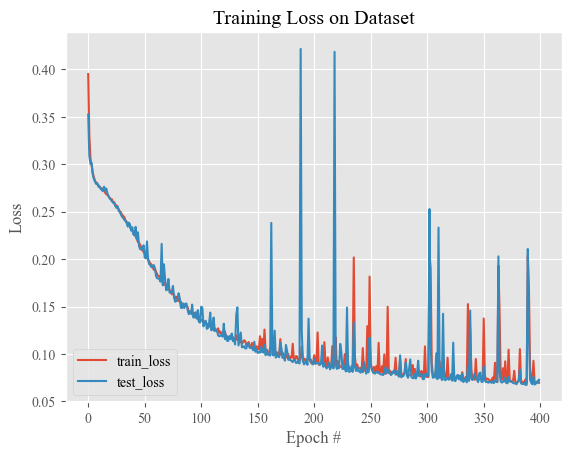

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(pathSavePlots + f'Training_Unet_GPU_04_v2.png',
            dpi=500,
            bbox_inches = 'tight',
            pad_inches=0.25)

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

# Save model

In [ ]:
path_save_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'
name_model = 'model_Unet_7ch_GPU_04_v2.pth' #
# el modelo 01 toma el AOI 1 y AOI 3 para el entrenamiento cada 2 imagenes
# el modelo 2 tien eun lr =  0.0001
# modelo 3 con 200 epocas lr = 0.0001
# modelo 4 .. 400 epocas

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)
torch.save(unet.state_dict(), path_save_models + name_model)

In [ ]:
os.listdir('/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models')

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'df_30models_LogReg.csv',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_0

# End